In [1]:
from sys import path

path.append("../")

from gc import collect as garbage_collect

from src.utils.experiment_info import ExperimentInfo
from src.utils.io import load_processed_data

In [3]:
path_to_experiment_info: str = "../data.nosync/mwc2022/all_experimento_info.csv"
experiment_info = ExperimentInfo(path=path_to_experiment_info, mode=2)

In [6]:
eda_data_base_path: str = "../data.nosync/mwc2022/filtered_artifacts/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/mwc2022/filtered_artifacts/*/ACC/*.parquet"

eda_data = load_processed_data(path=eda_data_base_path, file_format="parquet")
garbage_collect()

Loading data:   0%|          | 0/19 [00:00<?, ?it/s]

1588

In [7]:
artifact_data = {
        side : {user: eda_data[side][user]['Artifact']
         for user in eda_data[side].keys()}
    for side in eda_data.keys()
}
del eda_data

In [8]:
# count the number of artifacts, per user and per side, by doing the sum of the series
# and then divide it by the length of the series
artifact_count = {
    side : {user: artifact_data[side][user].sum() / len(artifact_data[side][user])
            for user in artifact_data[side].keys()}
    for side in artifact_data.keys()
}

In [9]:
import pandas as pd

artifact_count = pd.DataFrame.from_dict(artifact_count)
# make left and right into values in the column "side"
# artifact_count = artifact_count.reset_index().melt(id_vars="index", var_name="side", value_name="artifact_count")

In [10]:
artifact_count['sum'] = artifact_count['left'] + artifact_count['right']
# remove values who sum is 0
artifact_count = artifact_count[artifact_count['sum'] > 0.01]
artifact_count = artifact_count.drop(columns=['sum'], inplace=False)
artifact_count = artifact_count.reset_index().melt(id_vars="index", var_name="side", value_name="artifact_count")
artifact_count = artifact_count.rename(columns={'index': 'user'}, inplace=False)

In [11]:
artifact_count = artifact_count.sort_values(by=['user'], inplace=False)

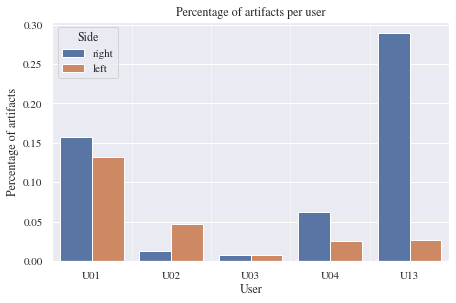

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

golden_ratio = (1 + 5 ** 0.5) / 2

# Set golden ratio figure size
figsize = 4.4
plt.figure(figsize=(figsize * golden_ratio, figsize))

# Set seaborn style
sns.set_style("darkgrid")

# Get a color palette
palette = sns.color_palette("colorblind", n_colors=4)

sns.set(font_scale=1)
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"


# Plot the barplot
ax = sns.barplot(data=artifact_count, x="user", y="artifact_count", hue="side")
plt.legend()
plt.title("Percentage of artifacts per user")
plt.xlabel("User")
plt.ylabel("Percentage of artifacts")

# Add vertical bars
for i in range(len(artifact_count["user"].unique()) - 1):
    plt.axvline(i + 0.5, color="white", linewidth=0.5)


plt.legend(title='Side')
plt.savefig("../final_visualizations/artifacts_mwc2022.pdf", bbox_inches="tight")
plt.show()
